# Описание
Алгоритм переноса стиля описан в статьях
[Perceptual Loss`es for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/pdf/1603.08155.pdf)
и [Instance Normalization](https://arxiv.org/pdf/1607.08022.pdf).

Официальный репозиторий авторов находится [тут](https://github.com/jcjohnson/fast-neural-style), pytorch версия описана
[здесь](https://github.com/pytorch/examples/blob/master/fast_neural_style).

## Импорт необходимых модулей

In [ ]:
from google.colab import files
files.upload() 

Saving transformernet.py to transformernet.py
Saving utils.py to utils.py
Saving vgg.py to vgg.py


{'transformernet.py': b'import torch\r\n\r\n\r\nclass TransformerNet(torch.nn.Module):\r\n    """Feedforward Transformation Network\r\n    reference: https://arxiv.org/abs/1603.08155\r\n    exact architecture: https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf\r\n    """\r\n    def __init__(self):\r\n        super(TransformerNet, self).__init__()\r\n        # Initial convolution layers\r\n        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)\r\n        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)\r\n        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)\r\n        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)\r\n        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)\r\n        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)\r\n        # Residual layers\r\n        self.res1 = ResidualBlock(128)\r\n        self.res2 = ResidualBlock(128)\r\n        self.res3 = ResidualBlock(128)\r\n        self.res4 = ResidualBlock(12

In [ ]:
import torch
from torchvision import models, datasets, transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.utils import save_image

from PIL import Image
from collections import namedtuple
import os
import sys
import time
import re
import numpy as np
import matplotlib.pyplot as plt
from transformernet import TransformerNet, ConvLayer, ResidualBlock, UpsampleConvLayer
import utils
from vgg import Vgg16
%matplotlib inline

## Обучение
Главная идея алгоритма заключается в обучении сверточной сети `Image Transform Net` с использованием `perceptual loss functions`. `Perceptual loss` измеряет разницу между высокоуровневыми признаками контентного и стилевого изображений, и дает более точные результаты в отношении переноса стиля, чем `per-pixel loss`.
Архитектура сети представлена [здесь](https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf).

![network](https://user-images.githubusercontent.com/37034031/42068027-830719f4-7b84-11e8-9e87-088f1e476aab.png)

В процессе обучения `Image Transform Net`, используется предобученная `Loss Network (VGG-16)` для определения компонентов `perceptual loss`. Веса
`Loss Network` остаются не изменными.

В инференс части используется только `Image Transform Net`, что позволяет очень быстро осуществлять перенос стиля с
одного изображения на другое.

In [ ]:
def train(args):
    device = torch.device("cuda" if args.cuda else "cpu")

    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    transform = transforms.Compose([
        transforms.Resize(args.image_size),
        transforms.CenterCrop(args.image_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    train_dataset = datasets.ImageFolder(args.dataset, transform)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size)

    transformer = TransformerNet().to(device)
    optimizer = Adam(transformer.parameters(), args.lr)
    mse_loss = torch.nn.MSELoss()

    vgg = Vgg16(requires_grad=False).to(device)

    style = utils.load_image(args.style_image, size=args.style_size)
    style = style.repeat(args.batch_size, 1, 1, 1).to(device)

    features_style = vgg(utils.normalize_batch(style))
    gram_style = [utils.gram_matrix(y) for y in features_style]

    for e in range(args.epochs):
        transformer.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0
        for batch_id, (x, _) in enumerate(train_loader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()

            x = x.to(device)
            y = transformer(x)

            y = utils.normalize_batch(y)
            x = utils.normalize_batch(x)

            features_y = vgg(y)
            features_x = vgg(x)

            content_loss = args.content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)

            style_loss = 0.
            for ft_y, gm_s in zip(features_y, gram_style):
                gm_y = utils.gram_matrix(ft_y)
                style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
            style_loss *= args.style_weight

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss.item()
            agg_style_loss += style_loss.item()

            if (batch_id + 1) % args.log_interval == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), e + 1, count, len(train_dataset),
                                  agg_content_loss / (batch_id + 1),
                                  agg_style_loss / (batch_id + 1),
                                  (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                print(mesg)

    # save model
    transformer.eval().cpu()
    save_model_filename = f"epoch_{args.epochs}_{time.ctime()}.pth"
    save_model_path = os.path.join(args.save_model_dir, save_model_filename)
    torch.save(transformer.state_dict(), save_model_path)

    print("\nDone, trained model saved at", save_model_path)

In [ ]:
def stylize(args):
    device = torch.device("cuda" if args.cuda else "cpu")

    content_image = utils.load_image(args.content_image, size=args.image_size)

    content_image = content_image.unsqueeze(0).to(device)

    with torch.no_grad():
        style_model = TransformerNet()
        style_model.load_state_dict(torch.load(args.model), strict=False)
        style_model.to(device)
        output = style_model(content_image).cpu()
    return output[0]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#GENERAL PARAM
SEED = 42
EPOCHS = 3
BATCH_SIZE = 4
DATASET = "/content/drive/My Drive/Images/"
STYLE_IMAGE = "/content/drive/My Drive/Images/Hendrix.jpg"
SAVE_MODEL_DIR = "/content/drive/My Drive/model/"
IMAGE_SIZE = 1500
STYLE_SIZE = 1500
CUDA = True
CONTENT_WEIGHT = 1e5
STYLE_WEIGHT = 1e10
LR = 1e-3
LOG_INTERVAL = 400
CONTENT_IMAGE = "/content/drive/My Drive/Images/west.jpg"
MODEL = "/content/drive/My Drive/model/hendrix.pth"


lst = ["seed", "epochs", "batch_size", "dataset", "style_image", 
       "content_image", "save_model_dir", "image_size", "style_size", 
       "cuda", "content_weight", "style_weight", 
       "lr", "log_interval", "output_image", "model"]

args = namedtuple('args', lst)
args = args._make([SEED, EPOCHS, BATCH_SIZE, DATASET, STYLE_IMAGE, CONTENT_IMAGE,
                   SAVE_MODEL_DIR, IMAGE_SIZE, STYLE_SIZE,
                   CUDA, CONTENT_WEIGHT, STYLE_WEIGHT, LR, 
                   LOG_INTERVAL, OUTPUT_IMAGE, MODEL])

In [ ]:
torch.cuda.is_available()

True

Модель обучим на ~6500 изображений с датасета `COCO`

In [ ]:
train(args)

Sat Feb  6 20:03:00 2021	Epoch 1:	[1600/6520]	content: 890548.440703	style: 1482302.512969	total: 2372850.953672
Sat Feb  6 20:11:30 2021	Epoch 1:	[3200/6520]	content: 860415.158711	style: 911656.686094	total: 1772071.844805
Sat Feb  6 20:19:57 2021	Epoch 1:	[4800/6520]	content: 818370.210286	style: 698128.512969	total: 1516498.723255
Sat Feb  6 20:28:25 2021	Epoch 1:	[6400/6520]	content: 781761.620488	style: 583314.490693	total: 1365076.111182
Sat Feb  6 20:31:02 2021	Epoch 2:	[1600/6520]	content: 624817.417344	style: 225712.130859	total: 850529.548203
Sat Feb  6 20:32:59 2021	Epoch 2:	[3200/6520]	content: 607708.170625	style: 221840.983867	total: 829549.154492
Sat Feb  6 20:34:57 2021	Epoch 2:	[4800/6520]	content: 592663.402474	style: 219887.646380	total: 812551.048854
Sat Feb  6 20:36:55 2021	Epoch 2:	[6400/6520]	content: 581427.161523	style: 217863.123623	total: 799290.285146
Sat Feb  6 20:39:05 2021	Epoch 3:	[1600/6520]	content: 533440.165703	style: 208614.380508	total: 742054.546

##Перенос стиля

In [ ]:
output = stylize(args)

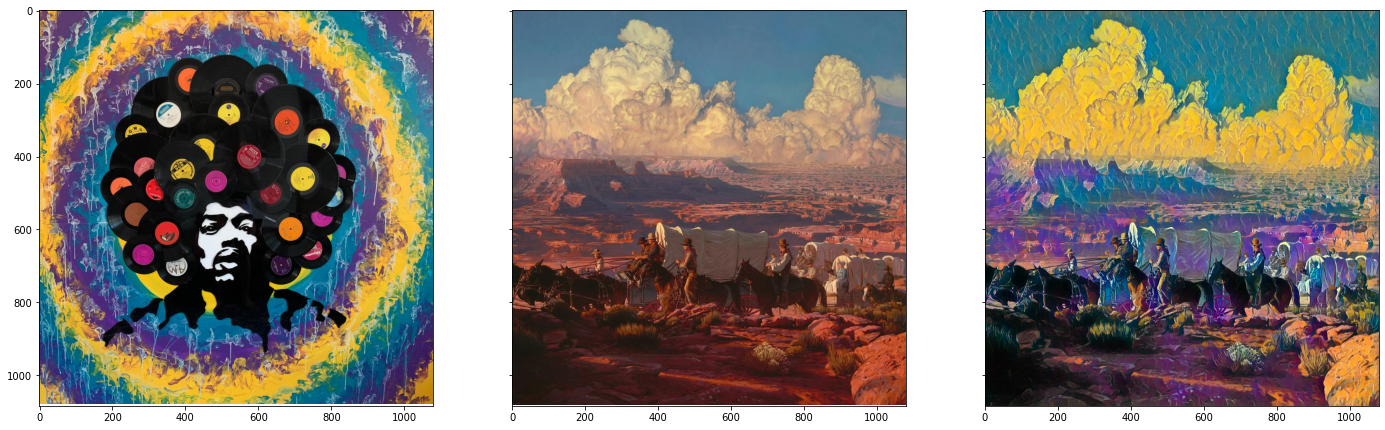

In [ ]:
content_image = utils.load_image(args.content_image)
style_img = utils.load_image(args.style_image)
fig, ax = plt.subplots(ncols=3,figsize=(24, 16), sharey=True, sharex=True)
imgs = [style_img, content_image, output]
for fig_x, img in zip(ax, imgs):
    utils.imshow(img, ax_plt=fig_x)